In [1]:
#import pytorch
import torch
from torch import nn
from torch.utils.data import DataLoader

#import torchvision
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

#Other libraries
import matplotlib.pyplot as plt

# Setting up datasets

In [2]:
train_data = datasets.FashionMNIST(
    root="../dataset", train=True, transform=ToTensor(), target_transform=None, download=True
)
test_data = datasets.FashionMNIST(
    root="../dataset", train=False, transform=ToTensor(), target_transform=None, download=True
)

In [3]:
print(f"Number of training images -> {len(train_data)} \nNumber of testing images -> {len(test_data)}")

Number of training images -> 60000 
Number of testing images -> 10000


In [4]:
class_names = train_data.classes
class_idx = train_data.class_to_idx
print(class_names,"\n",class_idx)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'] 
 {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}


## Data Visualization

In [5]:
img, target = train_data[0]
print(f"The image shape is {img.shape}\nThe label associated with the image is {target}")

The image shape is torch.Size([1, 28, 28])
The label associated with the image is 9


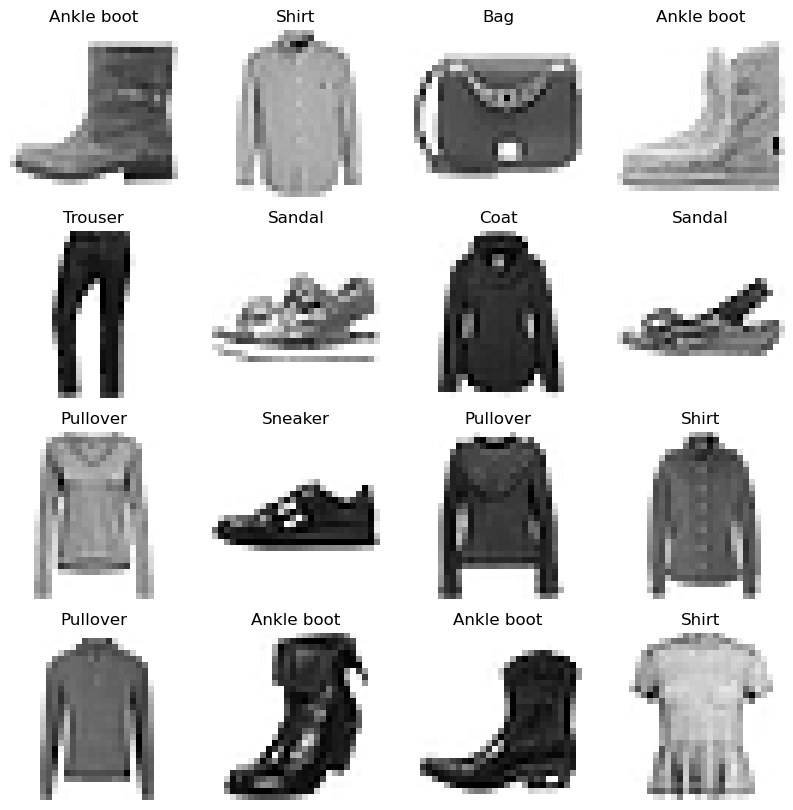

In [6]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 4,4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img,label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap=plt.cm.binary)
    plt.title(class_names[label])
    plt.axis(False)
# plt.show()

## Data loading

In [7]:
train_dataloader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=32,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
)

In [8]:
print(f"Number of batches for training:{len(train_dataloader)}\nNumber of batches for testing:{len(test_dataloader)}")

Number of batches for training:1875
Number of batches for testing:313


Images in a singular batch that is sent for training

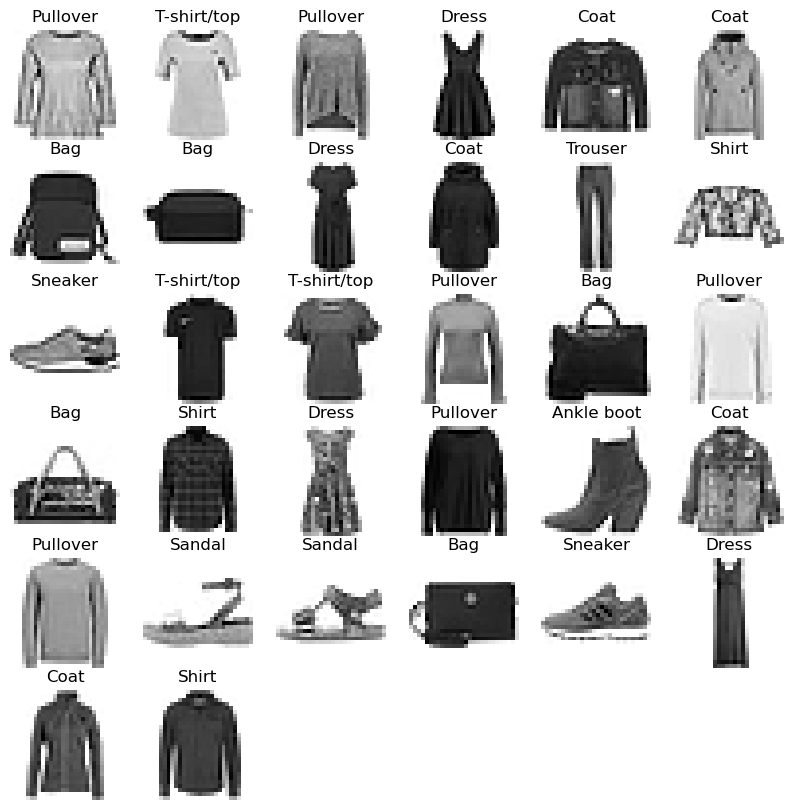

In [9]:
torch.manual_seed(42)
fig = plt.figure(figsize=(10, 10))
rows, cols = 6, 6
for i in range(1, rows*cols-3):
    train_features_batch, train_labels_batch = next(iter(train_dataloader))
    random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
    img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap=plt.cm.binary)
    plt.title(class_names[label])
    plt.axis(False)

# Baseline Model

In [10]:
flatten_model = nn.Flatten()
x = train_features_batch[0]
print(f"The shape before flatten: {x.shape}")
x = flatten_model(x)
print(f"The shape after flatten: {x.shape[1]}")
#[1,28,28] -> [1, 28*28=784]

The shape before flatten: torch.Size([1, 28, 28])
The shape after flatten: 784


In [11]:
class FahsionModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_shape: int, output_shape: int):
        super().__init__()
        self.block_1_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_shape,
                stride=1,
                kernel_size=3,
            ),
            nn.ReLU(),
        )
        self.block_1_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_shape,
                out_channels=hidden_shape,
                stride=2,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.block_2_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_shape,
                out_channels=hidden_shape,
                stride=1,
                kernel_size=3,
            ),
            nn.ReLU(),
        )
        self.block_2_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_shape,
                out_channels=hidden_shape,
                stride=2,
                kernel_size=3,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(in_features=hidden_shape*3*3, out_features=output_shape)
        )

    def forward(self, x) -> torch.float:
        input = self.block_1_1(x)
        # print(f"The shape after block1_1 is {input.shape}")
        block1_2 = self.block_1_2(input)
        # print(f"The shape after block1_2 is {block1_2.shape}")
        block2_1 = self.block_2_1(block1_2)
        # print(f"The shape after block2_1 is {block2_1.shape}")
        block2_2 = self.block_2_2(block2_1)
        # print(f"The shape after block2_2 is {block2_2.shape}")
        output = self.classifier(block2_2)
        # print(f"The shape after classifier is {output.shape}")
        return output


torch.manual_seed(42)
model = FahsionModelV0(
    input_shape=1,
    output_shape=len(class_names),
    hidden_shape=10,
).to("mps")

In [12]:
next(model.parameters()).device

device(type='mps', index=0)

Hence the prediction and the true values dont match

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer_fn = torch.optim.Adam(params=model.parameters(),
                                lr=0.001) 

In [14]:
def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = "mps",
):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = loss_fn(y_pred, y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [15]:
def test_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    accuracy_fn,
    device: torch.device = "cpu",
):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()  # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(
                y_true=y,
                y_pred=test_pred.argmax(dim=1),  # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [16]:
from tqdm.auto import tqdm
from helper_functions import accuracy_fn
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer_fn,
        accuracy_fn=accuracy_fn,
    )
    test_step(
        data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------


: 